In [5]:
%matplotlib notebook
import numpy as np
import os
import json
import sys

from pre_processing import gen_dataset
from wifi_localization import wifi_localization as wifi

import matplotlib.pyplot as plt

# configure the size of plot
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 12
fig_size[1] = 9

nano_to_sec = 1e09
micro_to_nano = 1e03

In [6]:
def query_position(scan, footprints, positions, bssid_map, k=3, verbose=False):
    assert len(footprints) == len(positions)
    assert len(footprints) >= k
    query_footprint, _ = wifi.build_wifi_footprint(scan, bssid_map)
    # nz = np.nonzero(query_footprint)[0]
    distances = []
    weights = []
    for i in range(len(footprints)):
        fp = footprints[i]
        dis = np.sort(query_footprint - fp, axis=0)
        distances.append({'id': i, 'dis': np.average(dis * dis)})
    distances = sorted(distances, key=lambda v: v['dis'])
    if verbose:
        for ele in distances:
            print(ele)
    query_pos = np.zeros(3, dtype=float)
    result_footprint = []
    result_ind = []
    weights = np.empty(k, dtype=float)
    for i in range(k):
        weights[i] = distances[i]['dis']
    weights /= np.sum(weights)
    
    for i in range(k):
        query_pos += positions[distances[i]['id']]
        result_footprint.append(footprints[distances[i]['id']])
        result_ind.append(distances[i]['id'])
    return query_pos / k, query_footprint, result_footprint, result_ind


def merge_grouped_records(wifi_records, grouping=1):
    assert len(wifi_records) % grouping == 0
    merged_records = [[] for _ in range(len(wifi_records) // grouping)]
    for gid in range(len(merged_records)):
        for scan in wifi_records[gid * grouping:(gid+1) * grouping]:
            for rec in scan:
                append_new = True
                if len(merged_records[gid]) > 0:
                    for ext_rec in merged_records[gid]:
                        if rec['BSSID'] == ext_rec['BSSID']:
                            append_new = False
                            ext_rec['level'] = max(ext_rec['level'], rec['level'])
                if append_new:
                    merged_records[gid].append(rec)
    return merged_records

    
def merge_grouped_records_with_stats(wifi_records, grouping=1):
    assert len(wifi_records) % grouping == 0
    merged_records = [[] for _ in range(len(wifi_records) // grouping)]
    for gid in range(len(merged_records)):
        local_records = {}
        # regroup the records by bssid
        for scan in wifi_records[gid * grouping:(gid+1) * grouping]:
            for rec in scan:
                if rec['BSSID'] in local_records:
                    local_records[rec['BSSID']].append({'t':rec['t'], 'level':rec['level']})
                else:
                    local_records[rec['BSSID']] = [{'t':rec['t'], 'level':rec['level']}]
        for bssid in local_records:
            ts = [v['t'] for v in local_records[bssid]]
            ls = [v['level'] for v in local_records[bssid]]
            mean_level = np.mean(ls)
            ls = ls + [0 for _ in range(grouping - len(ls))]
            merged_records[gid].append({'BSSID':bssid, 't': np.mean(ts), 'level':mean_level, 'std': np.std(ls)})
    return merged_records



Number of scans:  34
Number of all recs:  1685
Number of merged scans:  34
Number of all merged recs:  1685
34 records in the file ../../data/wifi/duc2


<IPython.core.display.Javascript object>


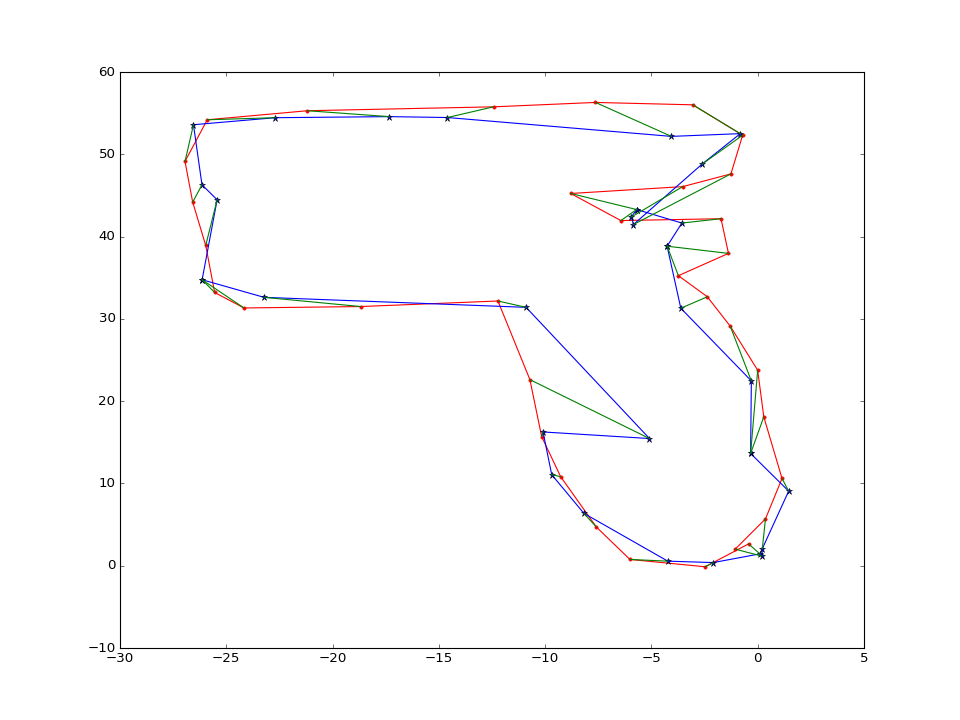

Mean positional error 3.495066m/165.802728m, largest error 10.127531, 2.11%


In [10]:
data_path = '../../data/wifi/duc2'

pose_data = np.genfromtxt(data_path + '/pose.txt')[:, :4]
wifi_data, redun = wifi.load_wifi_data(data_path + '/wifi.txt')

min_level = -80

wifi_data = wifi.reorder_wifi_records(wifi_data)
wifi_data = [wifi.filter_scan(scan, pose_data[0][0], pose_data[-1][0], min_level)
            for scan in wifi_data]
print('Number of scans: ', len(wifi_data))
print('Number of all recs: ', sum([len(v) for v in wifi_data]))

print('Number of merged scans: ', len(wifi_data))
print('Number of all merged recs: ', sum([len(v) for v in wifi_data]))

wifi_with_pose = []
for scan in wifi_data:
    if len(scan) == 0:
        continue
    scan_times = np.array([v['t'] for v in scan])
    rec_poses = gen_dataset.interpolate_3dvector_linear(pose_data, scan_times)
    for i in range(len(rec_poses)):
        scan[i]['pos'] = rec_poses[i][1:]
    wifi_with_pose.append(scan)
print('{} records in the file {}'.format(len(wifi_with_pose), data_path))

footprint_path = '../../models/wifi_duc2.json'
footprints, bssid_map, positions = wifi.read_wifi_foorprints(footprint_path)

query_positions = np.empty([len(wifi_with_pose), 3], dtype=float)
gt_positions = np.empty(query_positions.shape, dtype=float)
    
for i in range(len(wifi_with_pose)):
    _, gt_positions[i] = wifi.build_wifi_footprint(wifi_with_pose[i], bssid_map)

for i in range(0):
    plt.figure('Group {}'.format(i))
    base_ind = redun * i
    base_fp, _ = wifi.build_wifi_footprint(wifi_with_pose[base_ind], bssid_map)
    for j in range(redun):
        plt.subplot(100 * redun  + 11 + j)
        fp, _ = wifi.build_wifi_footprint(wifi_with_pose[base_ind + j], bssid_map)
        plt.plot(fp)
        plt.legend(['{:d}, {:.3f}'.format(base_ind + j, np.linalg.norm(fp - base_fp))])
    
k_neighbor = 3

plot_ind = []
for i in range(len(wifi_with_pose)):
    
    query_positions[i], query_footprint, nn_footprints, nn_ind = query_position(wifi_with_pose[i], footprints, 
                                                                        positions, bssid_map,
                                                                        k_neighbor)
    # nn_ind = np.arange(34, 42)
    if i in plot_ind:
        print('Ind:', nn_ind)
        plt.figure('Nearest neighbors for {}'.format(i))
        plt.subplot(100*(k_neighbor+1) + 11)
        plt.plot(query_footprint)
        nn_positions = np.empty([len(nn_footprints), 3])
        for j in range(len(nn_footprints)):
            nn_positions[j] = positions[nn_ind[j]]
            plt.subplot(100*(k_neighbor+1)+12+j)
            plt.plot(nn_footprints[j])
            plt.legend(['#{:d}: {:.3f}'.format(nn_ind[j], np.linalg.norm(nn_footprints[j] - query_footprint, ord=2))])
        
        plt.figure('position of nearest neighbors')
        plt.plot(gt_positions[:, 0], gt_positions[:, 1], color='r')
        plt.scatter(gt_positions[i, 0], gt_positions[i, 1], color='r', s=100)
        plt.scatter(query_positions[i, 0], query_positions[i, 1], color='g')
        plt.scatter(nn_positions[:, 0], nn_positions[:, 1], color='b')
        

plt.figure('Wifi localization')
plt.plot(gt_positions[:, 0], gt_positions[:, 1], color='r', marker='.')
plt.plot(query_positions[:, 0], query_positions[:, 1], color='b', marker='*')
    
for i in range(gt_positions.shape[0]):
    x = [gt_positions[i][0], query_positions[i][0]]
    y = [gt_positions[i][1], query_positions[i][1]]
    plt.plot(x, y, color='g')

traj_length = np.sum(np.linalg.norm(gt_positions[1:]-gt_positions[:-1], axis=1))
pos_error = np.linalg.norm(query_positions - gt_positions, axis=1)
mean_error = np.average(pos_error)
max_error = np.max(pos_error)
print('Mean positional error {:.6f}m/{:.6f}m, largest error {:.6f}, {:.2f}%'.format(mean_error, 
                                                                                    traj_length,
                                                                                    max_error,
                                                                                    mean_error / traj_length * 100))

## Fingerprints with stats

Number of scans:  310
Number of all recs:  23682
20 records in the file ../../data/wifi/cse_r5_1


<IPython.core.display.Javascript object>


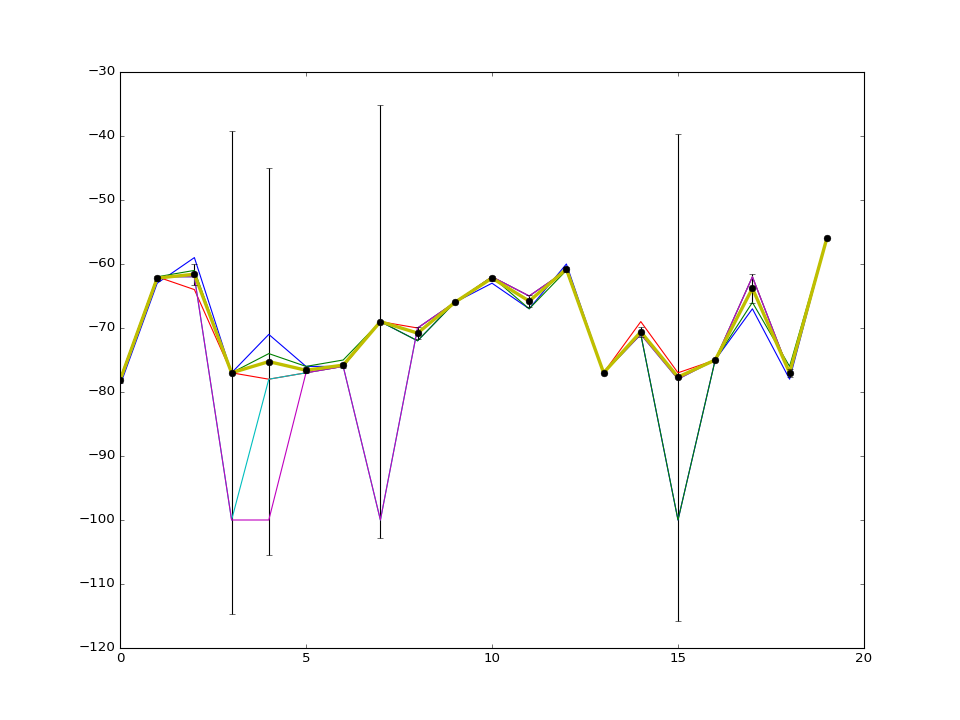

In [43]:
####################################################################################
# Training

def build_wifi_fingerprint_with_stats(scan, bssid_map, min_level=-100):
    assert len(scan) > 0
    assert 'std' in scan[0]
    fingerprint = [min_level for _ in range(len(bssid_map))]
    stdev = [0 for _ in range(len(bssid_map))]
    position = None
    if 'pos' in scan[0]:
        position = sum([v['pos'] for v in scan]) / float(len(scan))
    for rec in scan:
        if rec['BSSID'] in bssid_map:
            fingerprint[bssid_map[rec['BSSID']]] = rec['level']
            stdev[bssid_map[rec['BSSID']]] = rec['std']
    return np.array(fingerprint), np.array(stdev), position

# training
data_path = '../../data/wifi/cse_r5_1'
pose_data = np.genfromtxt(data_path + '/pose.txt')[:, :4]
wifi_data, redun = wifi.load_wifi_data(data_path + '/wifi.txt')

min_level = -80

# wifi_data = wifi.reorder_wifi_records(wifi_data)
wifi_data = [wifi.filter_scan(scan, pose_data[0][0], pose_data[-1][0], min_level)
            for scan in wifi_data]
print('Number of scans: ', len(wifi_data))
print('Number of all recs: ', sum([len(v) for v in wifi_data]))

wifi_with_stats = merge_grouped_records_with_stats(wifi_data, redun)

wifi_stats_with_pose = []
for scan in wifi_with_stats:
    if len(scan) == 0:
        continue
    scan_times = np.array([v['t'] for v in scan])
    rec_poses = gen_dataset.interpolate_3dvector_linear(pose_data, scan_times)
    for i in range(len(rec_poses)):
        scan[i]['pos'] = rec_poses[i][1:]
    wifi_stats_with_pose.append(scan)
print('{} records in the file {}'.format(len(wifi_with_pose), data_path))

bssid_map = wifi.build_bssid_map(wifi_stats_with_pose)
num_train = len(wifi_stats_with_pose)

positions = np.empty([num_train, 3], dtype=float)
fingerprints = np.empty([num_train, len(bssid_map)], )
stdevs = np.empty([num_train, len(bssid_map)])
for i in range(num_train):
    fingerprints[i], stdevs[i], positions[i] = build_wifi_fingerprint_with_stats(wifi_stats_with_pose[i], bssid_map)

trun = 20

for gid in range(1):
    plt.figure('split')
    for ind in range(gid*redun, (gid+1)*redun):
        fp, _ = wifi.build_wifi_footprint(wifi_data[ind], bssid_map)
        plt.plot(np.arange(0, trun), fp[:trun])
    fp, stdev, _ = build_wifi_fingerprint_with_stats(wifi_stats_with_pose[gid], bssid_map)
    plt.plot(np.arange(0, trun), fp[:trun], linewidth=3)
    plt.errorbar(np.arange(0, trun), fp[:trun], yerr=stdev[:trun], fmt='o')

Number of scans in test set:  20
Number of records in test set:  1582


<IPython.core.display.Javascript object>


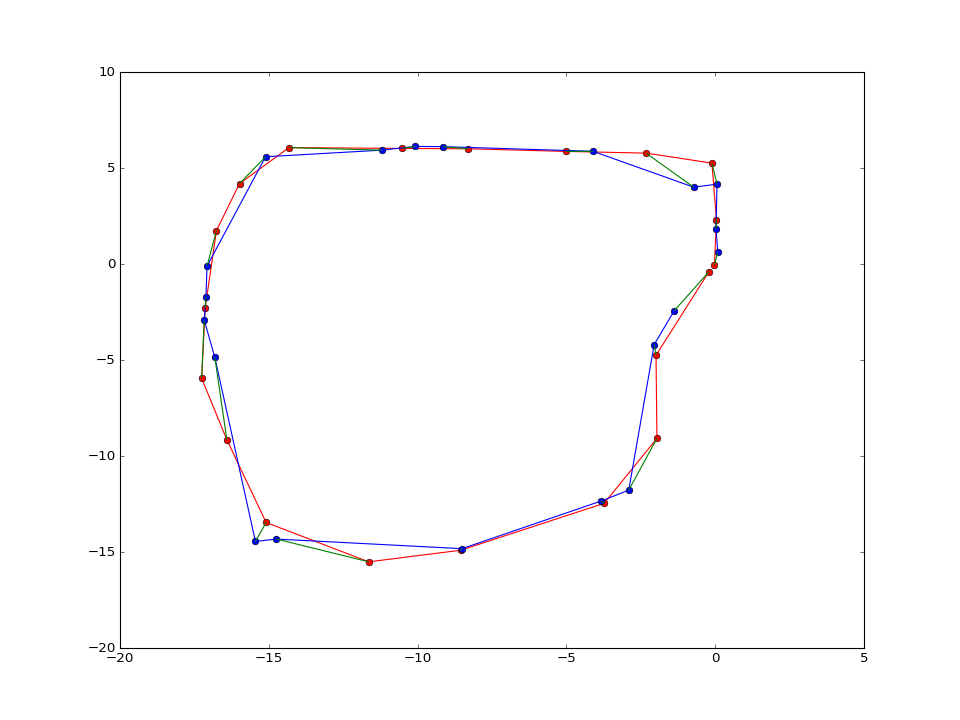

Mean positional error: 1.591m (2.43%)


In [44]:
#############################################################################################
# testing
def query_position_with_stats(scan, fingerprints, stdevs, positions, bssid_map, k, std_trun=1.0):
    stdevs = 1.0 / np.maximum(stdevs, std_trun)
    for i in range(stdevs.shape[0]):
        stdevs[i] /= np.sum(stdevs[i])
    fp, _ = wifi.build_wifi_footprint(scan, bssid_map)
    distances = []
    for i in range(len(fingerprints)):
        dis = np.dot((fingerprints[i] - fp) * (fingerprints[i] - fp), stdevs[i])
        distances.append({'id': i, 'dis': dis})
    distances = sorted(distances, key=lambda v: v['dis'])
    query_pos = np.zeros(3, dtype=float)
    weights = np.zeros(k)
    for i in range(k):
        weights[i] = 1.0 / (max(1e-5, distances[i]['dis']))
    weights /= np.sum(weights)
    nn_indices = []
    for i in range(k):
        query_pos += positions[distances[i]['id']] * weights[i]
        nn_indices.append(distances[i]['id'])
    return query_pos, nn_indices

k = 3
test_path = '../../data/wifi/cse2'
test_wifi_data, test_redun = wifi.load_wifi_data(test_path + '/wifi.txt')
test_pose_data = np.genfromtxt(test_path + '/pose.txt')[:, :4]

test_wifi_data = [wifi.filter_scan(scan, test_pose_data[0][0], test_pose_data[-1][0], min_level)
                 for scan in test_wifi_data]

print('Number of scans in test set: ', len(test_wifi_data))
print('Number of records in test set: ', sum([len(scan) for scan in test_wifi_data]))
test_fingerprints = []
test_positions = []
test_wifi_with_pose = []
for scan in test_wifi_data:
    if len(scan) == 0:
        continue
    scan_times = np.array([v['t'] for v in scan])
    rec_poses = gen_dataset.interpolate_3dvector_linear(test_pose_data, scan_times)
    for i in range(len(rec_poses)):
        scan[i]['pos'] = rec_poses[i][1:]
    test_wifi_with_pose.append(scan)

num_test = len(test_wifi_with_pose)
test_fingerprints = np.empty([num_test, len(bssid_map)])
test_positions = np.empty([num_test, 3])
test_gt_positions = np.empty([num_test, 3])
test_nn_inds = [None for _ in range(num_test)]
for i in range(num_test):
    test_fingerprints[i], test_gt_positions[i] = wifi.build_wifi_footprint(test_wifi_with_pose[i], bssid_map)
    test_positions[i], test_nn_inds[i] = query_position_with_stats(test_wifi_with_pose[i], fingerprints, stdevs, 
                                                  positions, bssid_map, k)

plt.figure('Query positions')
plt.plot(test_gt_positions[:, 0], test_gt_positions[:, 1], color='r', marker='o')
plt.plot(test_positions[:, 0], test_positions[:, 1], color='b', marker='o')
for i in range(test_positions.shape[0]):
    line = np.array([test_positions[i], test_gt_positions[i]])
    plt.plot(line[:, 0], line[:, 1], color='g')

track_length = np.sum(np.linalg.norm(test_gt_positions[1:] - test_gt_positions[:-1], axis=1))
pos_error = np.average(np.linalg.norm(test_positions - test_gt_positions, axis=1))
print('Mean positional error: {:.3f}m ({:.2f}%)'.format(pos_error, pos_error / track_length * 100))